# Incrementally saving sampling progress
### Can I save intermediate MCMC results for long runs, to avoid catastrophic loss of samples?
gully  
February 2016

In this notebook I explore how to save intermediate results of the MCMC sampling to an intermediate `hdf5` file.

This scenario is described in `emcee` [Advanced Patterns](http://dan.iel.fm/emcee/current/user/advanced/#incrementally-saving-progress) as "Incrementally saving progress":

>It is often useful to incrementally save the state of the chain to a file. This makes it easier to monitor the chain’s progress and it makes things a little less disastrous if your code/computer crashes somewhere in the middle of an expensive MCMC run. If you just want to append the walker positions to the end of a file, you could do something like:

```python3

f = open("chain.dat", "w")
f.close()

for result in sampler.sample(pos0, iterations=500, storechain=False):
    position = result[0]
    f = open("chain.dat", "a")
    for k in range(position.shape[0]):
        f.write("{0:4d} {1:s}\n".format(k, " ".join(position[k])))
    f.close()
    
```

### Where would I tell the code to save intermediate samples?
Let's start with the `demo1` run01 in the current repository (`starfish-demo`).  Try to sample a few hundred samples.

```bash
$ star.py --sample=ThetaPhi --samples=310
```

Now bring up the `star.py` script in the Starfish `scripts/` repo.

The `--samples` flag to `star.py` is passed to this main part of the code:

```python
sampler = StateSampler(lnprob, p0, cov, query_lnprob=query_lnprob, acceptfn=acceptfn, rejectfn=rejectfn, debug=True, outdir=Starfish.routdir)

p, lnprob, state = sampler.run_mcmc(p0, N=args.samples)
```

One **key insight** is that StateSampler is a subclass of `emcee.Sampler`...

In [1]:
from emcee.sampler import Sampler

In [2]:
def bogus_lnprob(p):
    return 1.0

In [3]:
samp = Sampler(3, bogus_lnprob)

In [4]:
samp.run_mcmc(     # Hit shift-tab...  also peak at samp.sample(), etc...

SyntaxError: unexpected EOF while parsing (<ipython-input-4-ca4a9da5143d>, line 1)

Based on reading the documentation and experimentation, I found no keyword arg (kwarg), that could be passed to achieve effortlessly the desired behavior.  But it did show a path forward:  Modify the `StateSampler.sample` class.

### A solution

I arrived at a fair solution:  Save every 100 samples to a numpy binary file.

`vals.tofile('chain_backup.npy')`

This strategy has the disadvantage that it has to rewrite (rather than append), the entire chain, which can grow quite large.  But since it only happens every 100 samples, that performance hit should not be too noticeable.

Specifically I modified this section of `Starfish/samplers.py`:

```python
            if storechain and i % thin == 0:
                ind = i0 + int(i / thin)
                self._chain[ind, :] = p
                self._lnprob[ind] = lnprob0

            # Save every 100 samples (hardcoded!):
            if ((i % 100) == 0) & (i > 100):
                self._chain.tofile('chain_backup.npy')

            # Heavy duty iterator action going on right here...
            yield p, lnprob0, self.random_state
```

I hardcoded 100 as the incremental spacing, but this could easily be made into a commandline argument and keyword arg with a default.  

### Try it out

In [7]:
import numpy as np

In [8]:
! ls

Incrementally_saving_progress.ipynb chain_backup.npy


In [9]:
chain = np.fromfile('chain_backup.npy')

In [10]:
chain.shape

(1860,)

That's slightly annoying... it saves as a flattened 1-D array.  We know there are 6 parameters, so we could do:

In [11]:
n_samples, dims = (chain.shape[0]//6, 6)

In [12]:
flatchain = chain.reshape((n_samples, dims))

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'svg' #could also do retina...

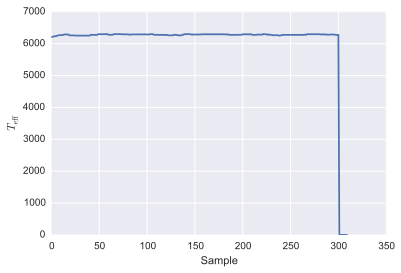

In [18]:
plt.plot(flatchain[:,0])
plt.ylabel('$T_{\mathrm{eff}}$'); plt.xlabel('Sample');

We sampled 310 iterations.  The code does not get to the final 10 samples because it only saves every 100.

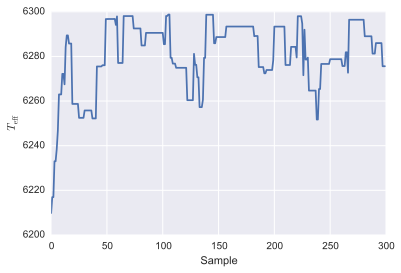

In [19]:
plt.plot(flatchain[0:300,0])
plt.ylabel('$T_{\mathrm{eff}}$'); plt.xlabel('Sample');

It works!


### Summary 
Well, I'll leave it at that for now.  There are much more elegant solutions, but I'll work with this for a while and see if it's worthy of improving and incorporating into the main codebase.

# The end.